In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import math
import skimage
from skimage import morphology
from skimage import img_as_float
from skimage import img_as_ubyte
from skimage import img_as_uint
from skimage import io
from scipy.ndimage.filters import convolve
from scipy import signal
from skimage.filters import threshold_otsu
from skimage.filters import rank
from skimage import img_as_float #convert img, we should use this function. Do Not Use np.astype
from skimage import util

#own library.
from retinaSeg import retinahelpfunction as rhf
from retinaSeg import retinapreprocess as rpp

In [2]:
'''
How to convert to skimage -> opencv 
    cvImg = skimage.astype("float") 
    cvimg = skimage.img_as_ubyte(skimage)

'''


def splitCh(img,debugOption = 'off'):
    """RGB image Split to red / green / blue ch 
    first, img is normalized in range [0,1] (min-max normalize)
    second, split image to red / green / blue ch.
    
    Parameters
    ----------
    img : 2-D Array
        numpy 2-D array
        opencv / sklearn / plt are avaliable.
        float / uint8 data type.
        
    debugOption : string type.
        'on' or 'off'
        default = 'off'
        
    Returns
    -------
        red / green / blue ch image
    
    Example
    -------
    >>> img = cv2.imread(path)
    >>> r,g, b = splitCh(img,'on')
    
    """

    oriImg =  img
    tempRed = oriImg[:,:,0]; tempGreen = oriImg[:,:,1] ; tempBlue = oriImg[:,:,2]
    #tempNorm = cv2.normalize(img_as_float(tempGreen), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
    #greenImg = tempNorm
    greenImg = tempGreen
    if debugOption == 'on':
        
        plt.axis("off")
        plt.title('original')
        plt.imshow(cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB))
        plt.show()
        
        plt.axis("off")
        plt.title('green ch')
        plt.imshow(greenImg,cmap='gray')
        plt.show()

        print("oriImg : {} greenImg : {} ".format(oriImg.dtype,greenImg.dtype))
    return greenImg


def khan_tophat_morphology(img,mask = None,debugOption = 'off'):
    """mordified top-hat transform 
    khan's tophat method.
    
    Parameters
    ----------
    img : 2-D Array
        numpy 2-D array
        opencv / sklearn / plt are avaliable.
        float / uint8 data type.
        
    mask : 2-D Array
        numpy 2-D array
        opencv / sklearn / plt are avaliable.
        float / uint8 data type.
        masking image. (for DRIVE database)
        
    debugOption : string type.
        'on' or 'off'
        on - draw image on jupyter notebook
        and print data type of local variable
        (default: 'off')
        
    Returns
    -------
        khan's tophat morphology result.
    
    Example
    -------
    >>> img = cv2.imread(path)
    >>> mask = cv2.imread(path)
    >>> result = khan_tophat_morphology(img,mask,'on')
    
    """
    
    #Previous version.
    #selm = morphology.disk(8)
    #closedImg = morphology.closing(tempTophat1, selm)
    #closeOpenImg = morphology.closing(closedImg, selm)
    strel1 = np.array([[0,0,1,1,1,1,1,1,1,1,1,0,0],
                    [0,1,1,1,1,1,1,1,1,1,1,1,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [0,1,1,1,1,1,1,1,1,1,1,1,0],
                    [0,0,1,1,1,1,1,1,1,1,1,0,0]],dtype='uint8')

    strel2 = np.array([[0,0,1,1,1,1,1,0,0],
                       [0,1,1,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [0,1,1,1,1,1,1,1,0],
                       [0,0,1,1,1,1,1,0,0]],dtype='uint8')
    
    tempStrel1 = morphology.rectangle(13,13)
    tempStrel2 = morphology.rectangle(9,9)
    
    tempTophat1 = img
    closedImg = cv2.morphologyEx(tempTophat1,cv2.MORPH_CLOSE,tempStrel1)
    closeOpenImg = cv2.morphologyEx(closedImg,cv2.MORPH_CLOSE,tempStrel2)
    temp1 = closeOpenImg < 0
    topHatMdfd= np.subtract(closeOpenImg,img)
    rhf.show_on_jupyter(closeOpenImg,'gray','fuck1')

    temp2 = topHatMdfd <0
    
    if mask != None:
        tempMaskImg = mask
        tempRow,tempCol = tempMaskImg.shape

        for row in range(tempRow):
            for col in range(tempCol):
                if tempMaskImg[row,col] > 0:
                    tempMaskImg[row,col] = 1
                else:
                    tempMaskImg[row,col] = 0

        tempMaskImg = tempMaskImg.astype('uint8')
        maskImg = morphology.erosion(tempMaskImg,strel2)        
        result = np.multiply(topHatMdfd,maskImg)
        

    else:
        result = topHatMdfd
    

    #Debugging
    if debugOption == 'on':
        print("tempTophat1 : {} closeOpenImg : {} topHatMdfd : {} ".format(tempTophat1.dtype,closeOpenImg.dtype,topHatMdfd.dtype))
        print("result : {} ".format(result.dtype))
        #print("tempMaskImg : {} maskStruc : {} maskImg : {} ".format(tempMaskImg.dtype,maskStruc.dtype,maskImg.dtype))
        
        plt.axis("off")
        plt.title('tophat')
        plt.imshow(result,cmap='gray')
        plt.show()

    return result

def khan_tophat_morphology2(img,mask = None,debugOption = 'off'):
    """mordified top-hat transform 
    khan's tophat method.
    
    Parameters
    ----------
    img : 2-D Array
        numpy 2-D array
        opencv / sklearn / plt are avaliable.
        float / uint8 data type.
        
    mask : 2-D Array
        numpy 2-D array
        opencv / sklearn / plt are avaliable.
        float / uint8 data type.
        masking image. (for DRIVE database)
        
    debugOption : string type.
        'on' or 'off'
        on - draw image on jupyter notebook
        and print data type of local variable
        (default: 'off')
        
    Returns
    -------
        khan's tophat morphology result.
    
    Example
    -------
    >>> img = cv2.imread(path)
    >>> mask = cv2.imread(path)
    >>> result = khan_tophat_morphology(img,mask,'on')
    
    """
    
    #Previous version.
    #selm = morphology.disk(8)
    #closedImg = morphology.closing(tempTophat1, selm)
    #closeOpenImg = morphology.closing(closedImg, selm)
    strel1 = np.array([[0,0,1,1,1,1,1,1,1,1,1,0,0],
                    [0,1,1,1,1,1,1,1,1,1,1,1,0],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1,1,1],
                    [0,1,1,1,1,1,1,1,1,1,1,1,0],
                    [0,0,1,1,1,1,1,1,1,1,1,0,0]],dtype='uint8')

    strel2 = np.array([[0,0,1,1,1,1,1,0,0],
                       [0,1,1,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1],
                       [0,1,1,1,1,1,1,1,0],
                       [0,0,1,1,1,1,1,0,0]],dtype='uint8')
    
    tempStrel1 = morphology.rectangle(19,19)
    tempStrel2 = morphology.rectangle(15,15)
    
    tempTophat1 = img
    closedImg = cv2.morphologyEx(tempTophat1,cv2.MORPH_CLOSE,tempStrel1)
    closeOpenImg = cv2.morphologyEx(closedImg,cv2.MORPH_OPEN,tempStrel2)
    rhf.show_on_jupyter(closeOpenImg,'gray','fuck1')
    '''
    for row in range(tempRow):
        for col in range(tempCol):
            if topHatMdfd[row,col] > 1:
                topHatMdfd[row,col] = 1
            elif topHatMdfd[row,col] < 0:
                topHatMdfd[row,col] = 0
    
    '''
    col,row = img.shape
    tempStack = img
    tempStack = np.dstack([tempStack,closeOpenImg] )
    
    stackResult = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            #print(result[i,j,:])
                stackResult[i,j] = np.min(tempStack[i,j,:])
    rhf.show_on_jupyter(stackResult,'gray','fuckk')

    topHatMdfd= np.subtract(img,stackResult)
    rhf.show_on_jupyter(topHatMdfd,'gray','fuck2')

    result = cv2.normalize(img_as_float(topHatMdfd), None, 0.0, 1.0, cv2.NORM_MINMAX)
    rhf.show_on_jupyter(result,'gray','fuck3')

    #Debugging
    if debugOption == 'on':
        print("tempTophat1 : {} closeOpenImg : {} topHatMdfd : {} ".format(tempTophat1.dtype,closeOpenImg.dtype,topHatMdfd.dtype))
        print("result : {} ".format(result.dtype))
        #print("tempMaskImg : {} maskStruc : {} maskImg : {} ".format(tempMaskImg.dtype,maskStruc.dtype,maskImg.dtype))
        
        plt.axis("off")
        plt.title('tophat')
        plt.imshow(result,cmap='gray')
        plt.show()

    return result

def eig2image(Dxx,Dxy,Dyy):

    Dxx=np.array(Dxx,dtype=float)
    Dyy=np.array(Dyy,dtype=float)
    Dxy=np.array(Dxy,dtype=float)
    if (len(Dxx.shape)!=2):
        return 0

    tmp = np.sqrt( (Dxx - Dyy)**2 + 4*Dxy**2)

    v2x = 2*Dxy
    v2y = Dyy - Dxx + tmp

    mag = np.sqrt(v2x**2 + v2y**2)
    i=np.array(mag!=0)

    v2x[i==True] = v2x[i==True]/mag[i==True]
    v2y[i==True] = v2y[i==True]/mag[i==True]

    v1x = -v2y 
    v1y = v2x

    mu1 = 0.5*(Dxx + Dyy + tmp)
    mu2 = 0.5*(Dxx + Dyy - tmp)

    check=abs(mu1)>abs(mu2)

    Lambda1=mu1.copy()
    Lambda1[check==True] = mu2[check==True]
    Lambda2=mu2
    Lambda2[check==True] = mu1[check==True]

    Ix=v1x
    Ix[check==True] = v2x[check==True]
    Iy=v1y
    Iy[check==True] = v2y[check==True]

    return Lambda1,Lambda2,Ix,Iy

def Hessian2D(I,Sigma):
    if Sigma<1:
        print("error: Sigma<1")
        return -1

    I=np.array(I,dtype=float)
    Sigma=np.array(Sigma,dtype=float)
    S_round=np.round(3*Sigma)

    [X,Y]= np.mgrid[-S_round:S_round+1,-S_round:S_round+1]

    DGaussxx = 1/(2*math.pi*pow(Sigma,4)) * np.multiply(X**2/pow(Sigma,2)-1,np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2))))
    DGaussxy = 1/(2*math.pi*pow(Sigma,6)) * np.multiply((X*Y) , np.exp(-(X**2 + Y**2)/(2*pow(Sigma,2))))   
    DGaussyy = np.transpose(DGaussxx)

    Dxx = signal.convolve2d(I,DGaussxx,boundary='fill',mode='same',fillvalue=0)
    Dxy = signal.convolve2d(I,DGaussxy,boundary='fill',mode='same',fillvalue=0)
    Dyy = signal.convolve2d(I,DGaussyy,boundary='fill',mode='same',fillvalue=0)

    return Dxx,Dxy,Dyy

def FrangiFilter2D(I):
    I=np.array(I,dtype=float)
    defaultoptions = {'FrangiScaleRange':(1,3), 'FrangiScaleRatio': 1.5, 'FrangiBetaOne':0.5, 'FrangiBetaTwo':15, 'verbose':True,'BlackWhite':True};  
    options=defaultoptions


    sigmas=np.arange(options['FrangiScaleRange'][0],options['FrangiScaleRange'][1],options['FrangiScaleRatio'])
    sigmas.sort()

    beta  = 2*pow(options['FrangiBetaOne'],2)  
    c     = 2*pow(options['FrangiBetaTwo'],2)

    shape=(I.shape[0],I.shape[1],len(sigmas))
    ALLfiltered=np.zeros(shape) 
    ALLangles  =np.zeros(shape) 

    AllDiffImg1 = np.zeros(shape)
    AllDiffImg2 = np.zeros(shape)

    AllLamda1 = np.zeros(shape)
    AllLamda2 = np.zeros(shape)

    #Frangi filter for all sigmas 
    Rb=0
    S2=0
    for i in range(len(sigmas)):
        #Show progress
        if(options['verbose']):
            print('Current Frangi Filter Sigma: ',sigmas[i])

        #Make 2D hessian
        [Dxx,Dxy,Dyy] = Hessian2D(I,sigmas[i])

        #Correct for scale 
        Dxx = pow(sigmas[i],2)*Dxx  
        Dxy = pow(sigmas[i],2)*Dxy  
        Dyy = pow(sigmas[i],2)*Dyy

        #Calculate (abs sorted) eigenvalues and vectors  
        [Lambda2,Lambda1,Ix,Iy]= eig2image(Dxx,Dxy,Dyy)  

        #Compute the direction of the minor eigenvector  
        angles = np.arctan2(Ix,Iy)  

        #Compute some similarity measures  
        Lambda1[Lambda1==0] = np.spacing(1)

        Rb = (Lambda2/Lambda1)**2  
        S2 = Lambda1**2 + Lambda2**2

        #Compute the output image
        Ifiltered = np.exp(-Rb/beta) * (np.ones(I.shape)-np.exp(-S2/c))

        #see pp. 45  
        if(options['BlackWhite']): 
            Ifiltered[Lambda1<0]=0
        else:
            Ifiltered[Lambda1>0]=0

        #store the results in 3D matrices  
        ALLfiltered[:,:,i] = Ifiltered 
        ALLangles[:,:,i] = angles

        AllDiffImg1[:,:,i] = Lambda1 - Lambda2
        AllDiffImg2[:,:,i] = Lambda2 - Lambda1

        AllLamda1[:,:,i] = Lambda1
        AllLamda2[:,:,i] = Lambda2
        # Return for every pixel the value of the scale(sigma) with the maximum   
        # output pixel value  

        if len(sigmas) > 1:
            outIm=ALLfiltered.max(2)
            diffImg1 = AllDiffImg1.max(2)
            diffImg2 = AllDiffImg2.max(2)
            lamda1Img = AllLamda1.max(2)
            lamda2Img = AllLamda2.max(2)

        else:
            outIm = (outIm.transpose()).reshape(I.shape)

    return outIm,diffImg1,diffImg2,lamda1Img,lamda2Img
   

def khan_otsu_method(img,debugOption = 'off'):
    
    strel3 = np.array([[0,0,1,1,1,1,1,1,1,0,0],
                       [0,1,1,1,1,1,1,1,1,1,0],
                       [1,1,1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1,1,1],
                       [1,1,1,1,1,1,1,1,1,1,1],
                       [0,1,1,1,1,1,1,1,1,1,0],
                       [0,0,1,1,1,1,1,1,1,0,0]],dtype='uint8')
    
    threshold_global_otsu = threshold_otsu(img)
    threshold_global_otsu = threshold_global_otsu + 0.02

    ret, global_otsu = cv2.threshold(img, threshold_global_otsu, 255, cv2.THRESH_BINARY)

    temp = global_otsu.astype('bool')
    result = morphology.remove_small_objects(temp,30)
    closeOtsu =  morphology.dilation(temp,strel3)

    if debugOption == 'on':
        print('thresold value : {}'.format(threshold_global_otsu))
        print("global_otsu : {} ".format(global_otsu.dtype))
        
        plt.axis("off")
        plt.title('otsu debugging')
        plt.imshow(temp,cmap='gray')
        plt.show()
        
        plt.axis("off")
        plt.title('otsu debugging')
        plt.imshow(result,cmap='gray')
        plt.show()

    return result

def rotate_line_opening(img,rotateNum,length,option = 'sup'):
    col,row = img.shape
    result = img
    degree = 180 / rotateNum
    
    for cnt in range(rotateNum+1):
        if cnt ==0:
            temp = morphology.opening(img,rhf.strel_line(length,degree * cnt))
            result = temp
            
        rotateSe1 = rhf.strel_line(length,degree *cnt)
        temp = morphology.opening(img,rotateSe1)
        result = np.dstack([result,temp] )
        
    
    for cnt in range(rotateNum+1):
        rhf.show_on_jupyter(result[:,:,cnt],'gray',str(degree * cnt))
    
    finalResult = np.zeros((col,row))
    print(result.shape)
    for i in range(col):
        for j in range(row):
            #print(result[i,j,:])
            if option =='sup':
                finalResult[i,j] = np.max(result[i,j,:])
            elif option == 'inf':
                finalResult[i,j] = np.min(result[i,j,:])
    
    print(finalResult.shape)
    #print(finalResult)
    #rhf.show_on_jupyter(img,'gray','original')
    #rhf.show_on_jupyter(finalResult,'gray','result')
    return finalResult

def process_hessian(img,debugOption = 'on'):
    tempTophat = img
    hessImg, hessDiff1, hessDiff2, tempLamda1,tempLamda2 = FrangiFilter2D(tempTophat)
    tempHess1 = hessDiff1
    tempHess2 = hessDiff2
    hessDiff1 = cv2.normalize(img_as_float(hessDiff1), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
    hessDiff2 = cv2.normalize(img_as_float(hessDiff2), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
    hessImg = hessImg * 50000
    if debugOption == 'on':

        print("hessImg : {} hessDiff1 : {} hessDiff2 : {} ".format(hessImg.dtype,hessDiff1.dtype,hessDiff2.dtype))
        print("tempLamb1 : {} tempLamb2 : {}".format(tempLamda1.dtype,tempLamda2.dtype))
        rhf.show_on_jupyter(hessImg,'gray')
        rhf.show_on_jupyter(hessDiff1,'gray','L1-L2')
        #show_on_jupyter(tempNormHess1,'gray','Norm L1-L2')
        rhf.show_on_jupyter(hessDiff2,'gray','L2-L1')
        #show_on_jupyter(tempNormHess2,'gray','Norm L2-L1')
        rhf.show_on_jupyter(tempLamda1,'gray')
        rhf.show_on_jupyter(tempLamda2,'gray')
    
    return hessImg, hessDiff1, hessDiff2


In [3]:
'''

def process_hessian(self):
    #Run Hessian Process

    self.hessImg, self.hessDiff1, self.hessDiff2, tempLamda1,tempLamda2 = self.FrangiFilter2D(self.tophatImg)
    print(self.hessDiff1[200,200])
    #print(self.hessDiff1[200:400, 200:400])
    tempHess1 = self.hessDiff1
    tempHess2 = self.hessDiff2
    self.hessDiff1 = cv2.normalize(img_as_float(self.hessDiff1), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
    self.hessDiff2 = cv2.normalize(img_as_float(self.hessDiff2), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point
    #print(self.hessDiff1)
    print(np.mean(tempHess1))

    ############# Check the Data type ###################
    print("#####################################################")
    print("hessImg : {} hessDiff1 : {} hessDiff2 : {} ".format(self.hessImg.dtype,self.hessDiff1.dtype,self.hessDiff2.dtype))
    print("tempLamb1 : {} tempLamb2 : {}".format(tempLamda1.dtype,tempLamda2.dtype))
    #print("tempNormH1 : {}, tempNormH2 {}".format(tempNormHess1.dtype,tempNormHess2.dtype))
    print("#####################################################")
    #####################################################

    show_on_jupyter(self.hessImg * 50000,'gray')
    show_on_jupyter(self.hessDiff1,'gray','L1-L2')
    #show_on_jupyter(tempNormHess1,'gray','Norm L1-L2')
    show_on_jupyter(self.hessDiff2,'gray','L2-L1')
    #show_on_jupyter(tempNormHess2,'gray','Norm L2-L1')
    show_on_jupyter(tempLamda1,'gray')
    show_on_jupyter(tempLamda2,'gray')
    #cv2.imwrite("frangil.png",self.hessImg)
    #cv2.imwrite("Lambda1_2.png",self.hessDiff1)

'''

'\n\ndef process_hessian(self):\n    #Run Hessian Process\n\n    self.hessImg, self.hessDiff1, self.hessDiff2, tempLamda1,tempLamda2 = self.FrangiFilter2D(self.tophatImg)\n    print(self.hessDiff1[200,200])\n    #print(self.hessDiff1[200:400, 200:400])\n    tempHess1 = self.hessDiff1\n    tempHess2 = self.hessDiff2\n    self.hessDiff1 = cv2.normalize(img_as_float(self.hessDiff1), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point\n    self.hessDiff2 = cv2.normalize(img_as_float(self.hessDiff2), None, 0.0, 1.0, cv2.NORM_MINMAX) # Convert to normalized floating point\n    #print(self.hessDiff1)\n    print(np.mean(tempHess1))\n\n    ############# Check the Data type ###################\n    print("#####################################################")\n    print("hessImg : {} hessDiff1 : {} hessDiff2 : {} ".format(self.hessImg.dtype,self.hessDiff1.dtype,self.hessDiff2.dtype))\n    print("tempLamb1 : {} tempLamb2 : {}".format(tempLamda1.dtype,tempLamda2.dtype))\n    #

In [4]:
vesselPath1 = "./18.06.25/Image__2018-06-25__14-55-38.jpg"
vesselPath4 = "./data/18.06.25/Image__2018-06-25__15-23-15.bmp"
vesselPath2 = "./18.06.25/vessel01_18_08_03.jpeg"
vesselPath3 = "./18.06.25/vessel02_18_08_03.jpeg"
vesselPath5 = "./data/corrected.tif"

path1 = "./DRIVE/DRIVE/test/images/20_test.tif"
path2 = "./DRIVE/DRIVE/test/mask/20_test_mask.gif"


vesselImg = io.imread(vesselPath5)
temp01 = io.imread(vesselPath4)

FileNotFoundError: [Errno 2] No such file or directory: './data/18.06.25/Image__2018-06-25__15-23-15.bmp'

In [4]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

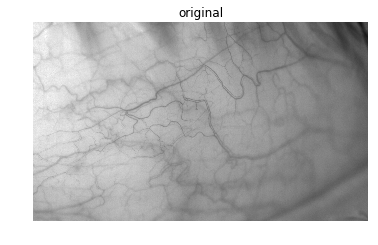

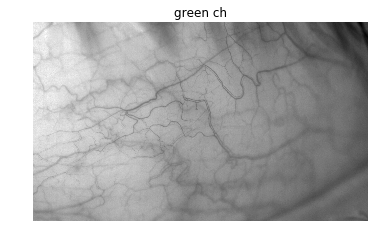

oriImg : uint8 greenImg : uint8 


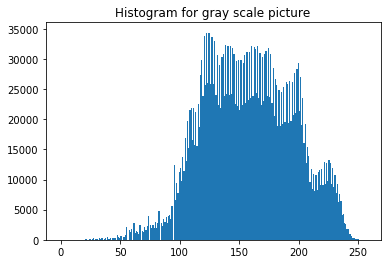

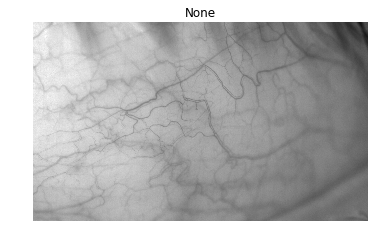

In [8]:
step1 = splitCh(temp01,debugOption='on')
rhf.show_histogram(temp01,'gray')
rhf.show_on_jupyter(temp01,'gray')

data type 

corImg : uint8, backImg : uint8, resultImg : float64


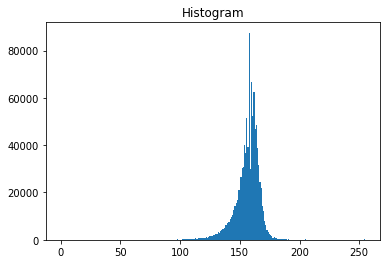

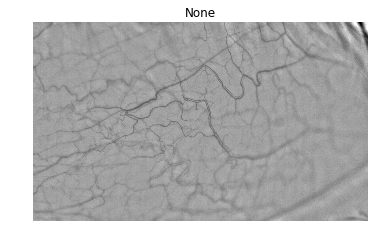

/Users/hyeonwoojeong/.pyenv/versions/3.5.5/envs/bonoProjects/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


data type img : float64 clahe : float64


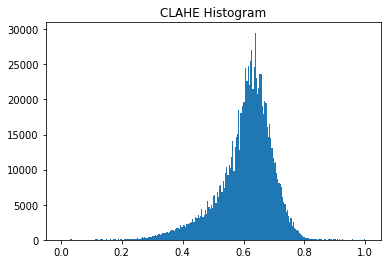

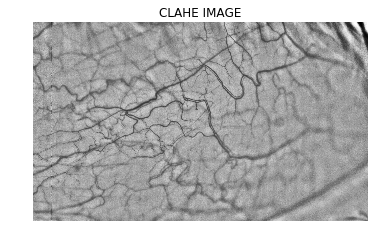

In [9]:
step2 = rpp.correction_non_uniform_back(step1,37,debug_option='on')
rhf.show_on_jupyter(step2,'gray')
step3 = rpp.clahe_preprocessing(step2,debug_option='on')

/Users/hyeonwoojeong/.pyenv/versions/3.5.5/envs/bonoProjects/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


data type img : uint8 clahe : float64


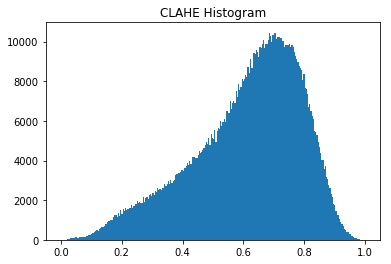

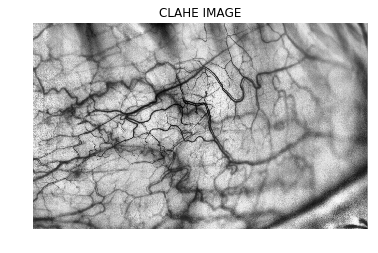

In [21]:
#gray img
step3 = rpp.clahe_preprocessing(vesselImg,debug_option='on')

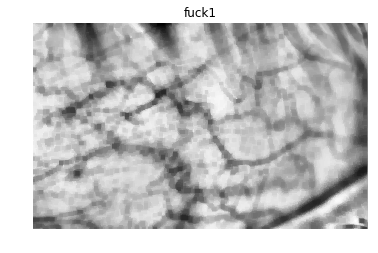

tempTophat1 : float64 closeOpenImg : float64 topHatMdfd : float64 
result : float64 


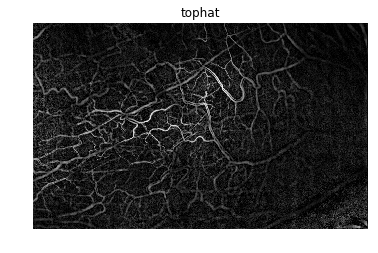

data type 

corImg : uint8, backImg : uint8, resultImg : float64


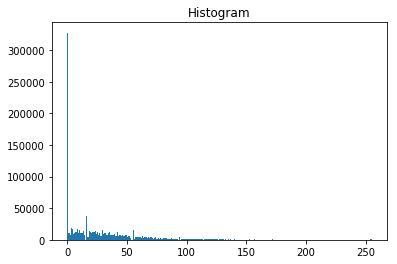

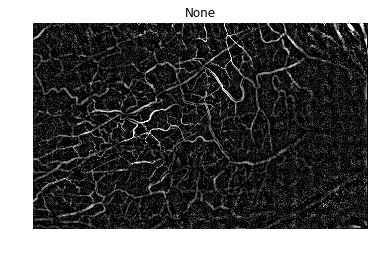

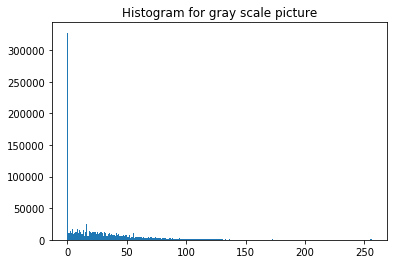

In [24]:
step4 = khan_tophat_morphology(step3,debugOption='on')
step4 = interval_mapping(step4,0.0,1.0,0,255).astype('uint8')
step4 = rpp.correction_non_uniform_back(step4,37,debug_option='on')
rhf.show_on_jupyter(step4,'gray')
rhf.show_histogram(step4,'gray')

Current Frangi Filter Sigma:  1.0
Current Frangi Filter Sigma:  2.5
hessImg : float64 hessDiff1 : float64 hessDiff2 : float64 
tempLamb1 : float64 tempLamb2 : float64


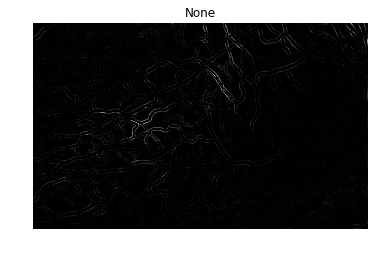

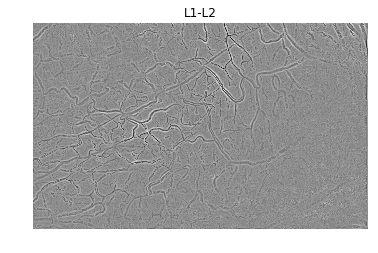

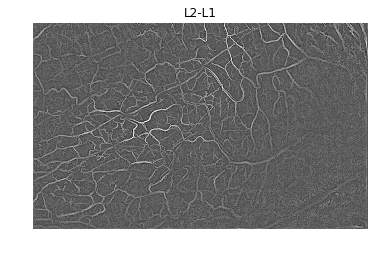

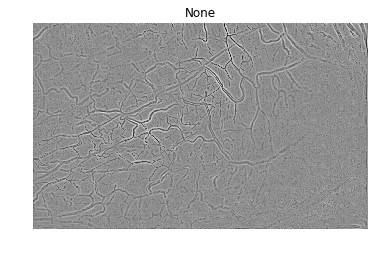

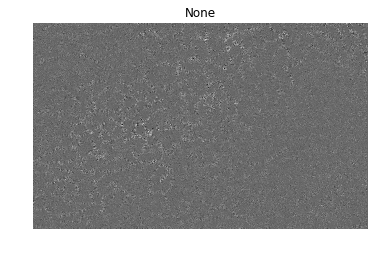

thresold value : 0.424296875
global_otsu : float64 


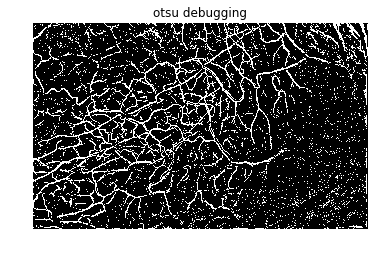

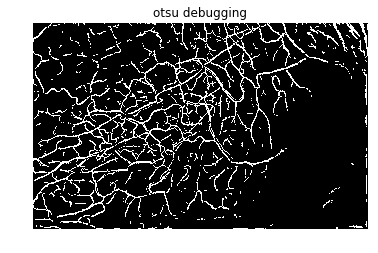

thresold value : 0.217265625
global_otsu : float64 


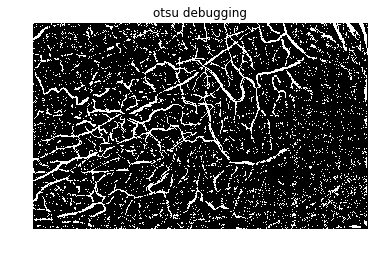

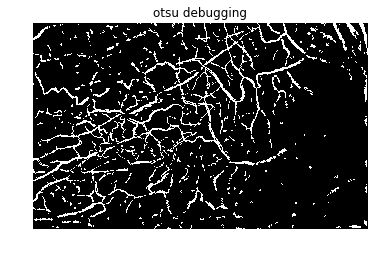

In [25]:
step4 = cv2.normalize(img_as_float(step4), None, 0.0, 1.0, cv2.NORM_MINMAX)
step5,step5_1,step5_2 = process_hessian(step4,debugOption='on')
step6 = khan_otsu_method(step5_2,debugOption='on')
step6_1 = khan_otsu_method(step4,debugOption='on')

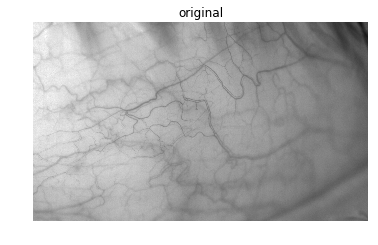

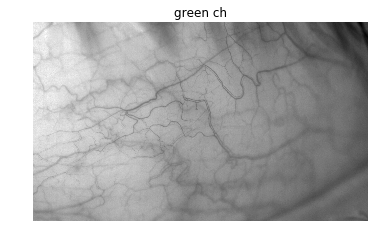

oriImg : uint8 greenImg : uint8 


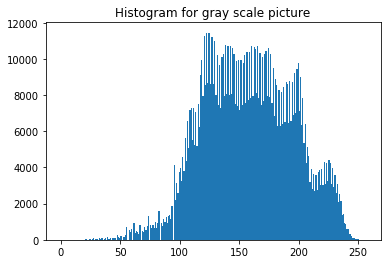

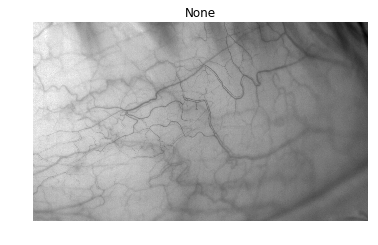

data type 

corImg : uint8, backImg : uint8, resultImg : float64


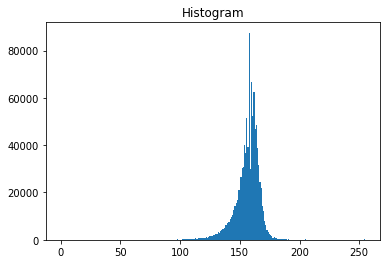

/Users/hyeonwoojeong/.pyenv/versions/3.5.5/envs/bonoProjects/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


data type img : float64 clahe : float64


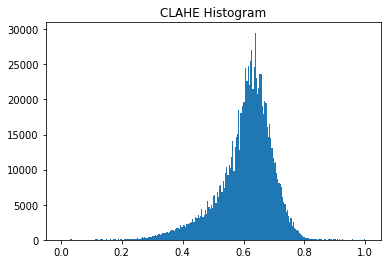

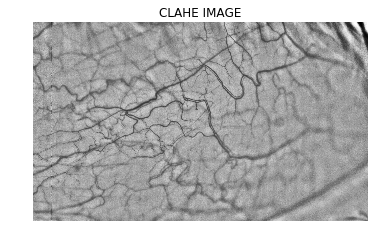

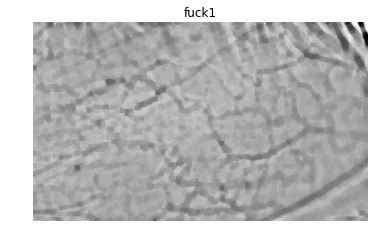

tempTophat1 : float64 closeOpenImg : float64 topHatMdfd : float64 
result : float64 


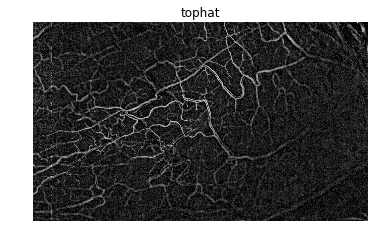

data type 

corImg : uint8, backImg : uint8, resultImg : float64


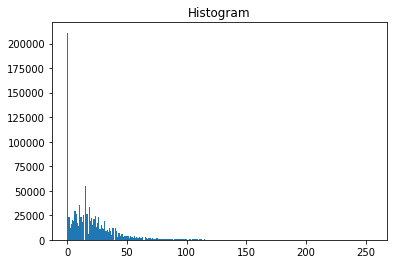

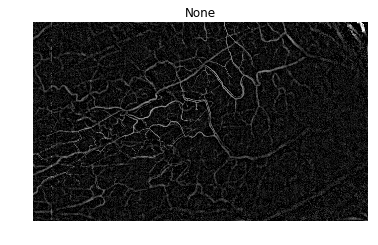

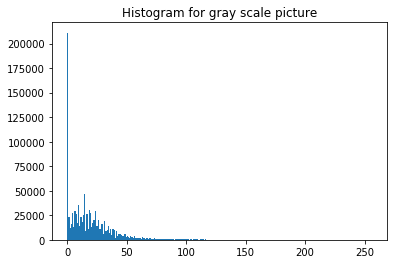

Current Frangi Filter Sigma:  1.0
Current Frangi Filter Sigma:  2.5
hessImg : float64 hessDiff1 : float64 hessDiff2 : float64 
tempLamb1 : float64 tempLamb2 : float64


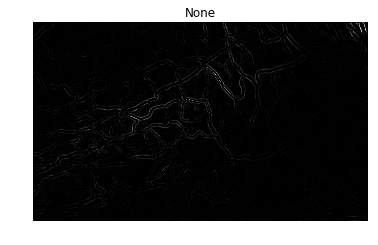

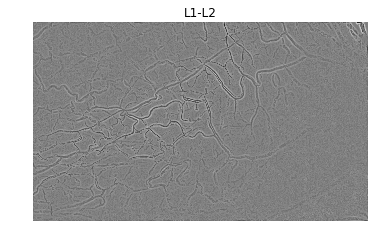

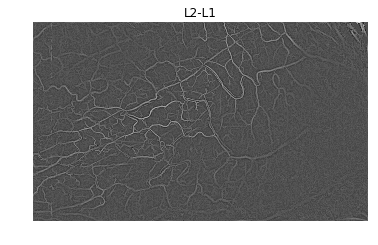

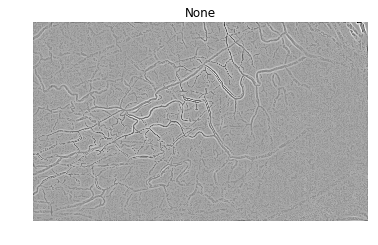

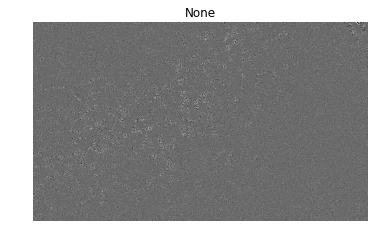

thresold value : 0.369609375
global_otsu : float64 


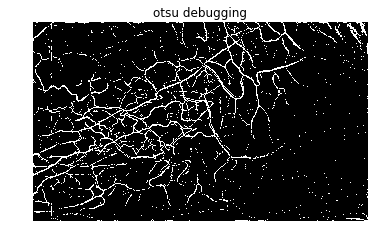

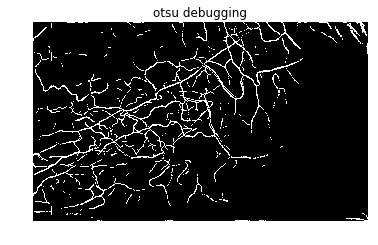

thresold value : 0.150859375
global_otsu : float64 


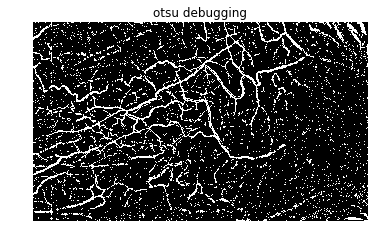

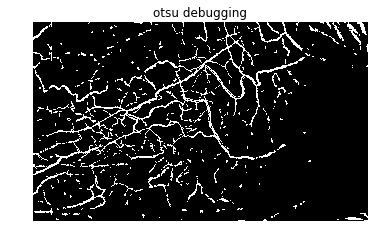

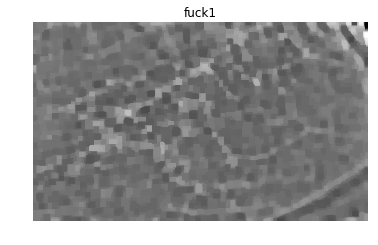

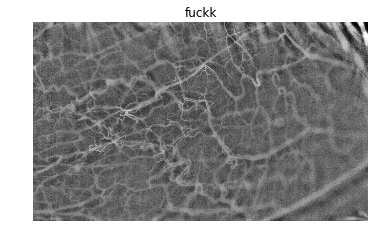

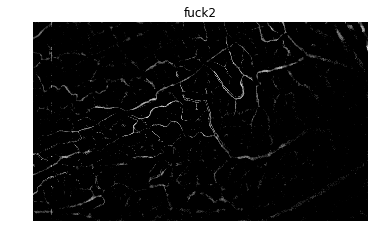

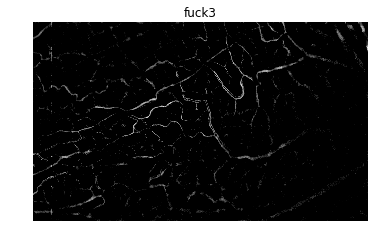

tempTophat1 : float64 closeOpenImg : float64 topHatMdfd : float64 
result : float64 


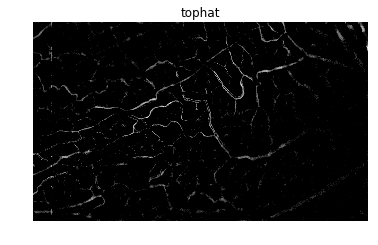

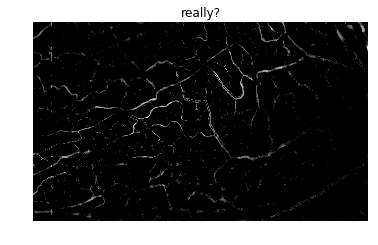

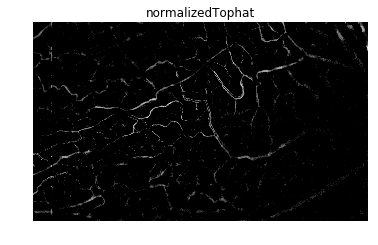

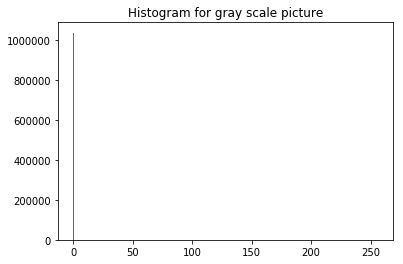

Current Frangi Filter Sigma:  1.0
Current Frangi Filter Sigma:  2.5
hessImg : float64 hessDiff1 : float64 hessDiff2 : float64 
tempLamb1 : float64 tempLamb2 : float64


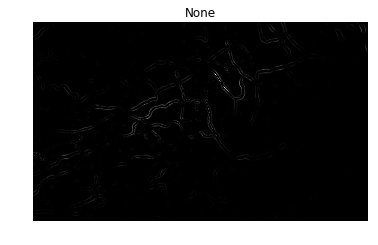

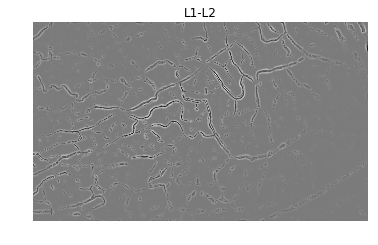

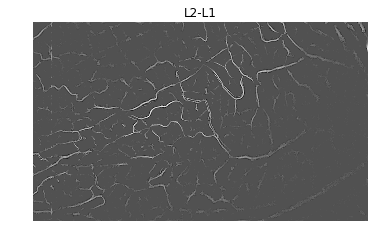

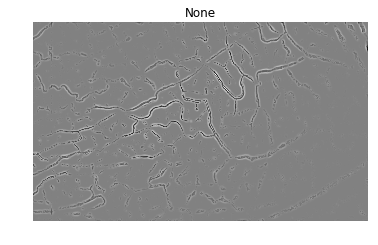

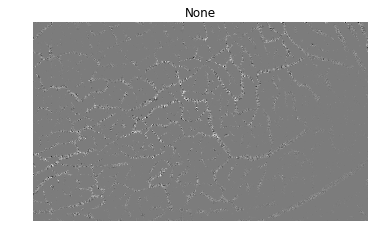

thresold value : 0.439921875
global_otsu : float64 


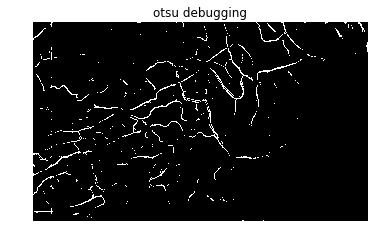

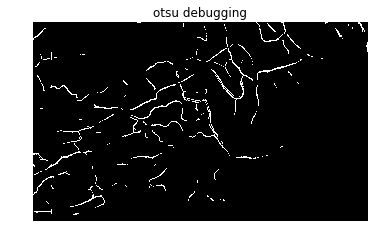

thresold value : 0.182109375
global_otsu : float64 


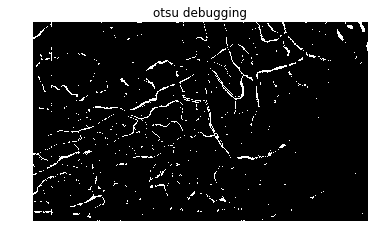

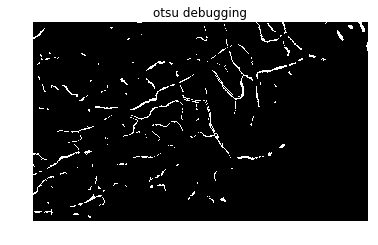

In [47]:
step1 = splitCh(vesselImg,debugOption='on')
rhf.show_histogram(step1,'gray')
rhf.show_on_jupyter(step1,'gray')
step2 = rpp.correction_non_uniform_back(step1,37,debug_option='on')
step3 = rpp.clahe_preprocessing(step2,debug_option='on')
step4 = khan_tophat_morphology(step3,debugOption='on')
step4 = interval_mapping(step4,0.0,1.0,0,255).astype('uint8')
step4 = rpp.correction_non_uniform_back(step4,37,debug_option='on')
rhf.show_on_jupyter(step4,'gray')
rhf.show_histogram(step4,'gray')
step4 = cv2.normalize(img_as_float(step4), None, 0.0, 1.0, cv2.NORM_MINMAX)
step5,step5_1,step5_2 = process_hessian(step4,debugOption='on')
step6 = khan_otsu_method(step5_2,debugOption='on')
step6_1 = khan_otsu_method(step4,debugOption='on')

step3 = util.invert(step3)

tempStep4 = khan_tophat_morphology2(step3,debugOption='on')
rhf.show_on_jupyter(tempStep4,'gray','really?')
#tempStep4 = interval_mapping(tempStep4,0.0,1.0,0,255).astype('uint8')
#tempStep4 = rpp.correction_non_uniform_back(tempStep4,37,debug_option='on')
rhf.show_on_jupyter(tempStep4,'gray','normalizedTophat')
rhf.show_histogram(tempStep4,'gray')
tempStep4 = cv2.normalize(img_as_float(tempStep4), None, 0.0, 1.0, cv2.NORM_MINMAX)
step5,step5_1,step5_2 = process_hessian(tempStep4,debugOption='on')
step6 = khan_otsu_method(step5_2,debugOption='on')
step6_1 = khan_otsu_method(tempStcep4,debugOption='on')

# 어떨때 Hessian 이 잘 enhance되는가
# Logic 정리.


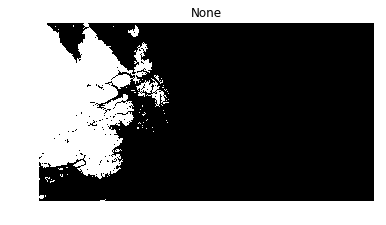

In [110]:
ret, global_otsu = cv2.threshold(step1, 170, 255, cv2.THRESH_BINARY)
rhf.show_on_jupyter(global_otsu,'gray')

In [37]:
tempStrel1 = morphology.rectangle(13,13)
tempStrel2 = morphology.rectangle(9,9)

tempStrel1


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)